<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Simulates a multi-crystal amplifier with BELLA Center's parameters</b>
<br>A 3-crystal configuration, with 4, 3, 3 passes per crystal
</div>

In [1]:
# Laser pulse
num_laser_slices = 41

# Crystal
num_crystal_slices = 3

gain = 1 
radial_n2 = 0
prop_type = 'n0n2_srw'

beamsplitter_transmitted_frac = 0.4

In [2]:
def plot_excited_states(crystal):
    long_excited_states, trans_excited_states = crystal.extract_excited_states()
    z = np.linspace(0,2.5,len(long_excited_states))
    x = np.linspace(-crystal.params.pop_inversion_mesh_extent,
                    crystal.params.pop_inversion_mesh_extent,
                    crystal.params.pop_inversion_n_cells)

    uti_plot.uti_plot2d1d(
        trans_excited_states.flatten(),
        [-crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_n_cells],
        [-crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_mesh_extent, crystal.params.pop_inversion_n_cells],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Total Num Excited States'],
        ['m', 'm', 'num'],
        True)
    
    fig = plt.figure()
    ax = fig.gca()
    plt.pcolormesh(x*(1e3), x*(1e3), trans_excited_states, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Vertical Position [mm]')
    ax.set_xlabel(r'Horizontal Position [mm]')
    ax.set_title('Total Num Excited States')
    plt.show()
    
    plt.figure()
    plt.plot(z,long_excited_states, 'k')
    plt.xlabel('Longitudinal Distance [cm]')
    plt.ylabel('Num Excited States')
    plt.show()

In [3]:
def plot_all(laser_pulse):
    wfr_temp = laser_pulse.slice[0].wfr
    wfr_x = np.linspace(wfr_temp.mesh.xStart,wfr_temp.mesh.xFin,wfr_temp.mesh.nx)
    wfr_y = np.linspace(wfr_temp.mesh.yStart,wfr_temp.mesh.yFin,wfr_temp.mesh.ny)

    e_total_init = laser_pulse.extract_total_2d_elec_fields()
    intens_2d_init = 0.5 *const.c *const.epsilon_0 *(e_total_init.re**2.0 + e_total_init.im**2.0)
    intens0 = intens_2d_init.flatten()

    uti_plot.uti_plot2d1d(
        intens0,
        [wfr_temp.mesh.xStart, wfr_temp.mesh.xFin, wfr_temp.mesh.nx],
        [wfr_temp.mesh.yStart, wfr_temp.mesh.yFin, wfr_temp.mesh.ny],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Intensity'],
        ['m', 'm', 'ph/s/.1%bw/mm^2'],
        True)

    x_min = np.abs(-15.0 - wfr_x*1e3).argmin(axis=0) - 1
    x_max = np.abs(15.0 - wfr_x*1e3).argmin(axis=0) + 1
    
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(4.6*1.5,3.6*1.5))
        ax = fig.gca()
        plt.pcolormesh(wfr_x[x_min:x_max]*(1e3), wfr_y[x_min:x_max]*(1e3), intens_2d_init[x_min:x_max,x_min:x_max], cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        # plt.xlim(-15,15)
        # plt.ylim(-15,15)
        ax.set_title('Intensity')
        plt.show()
    
    phase_2d_init = laser_pulse.extract_total_2d_phase()
    phase0 = phase_2d_init.flatten()

    uti_plot.uti_plot2d1d(
        phase0,
        [wfr_temp.mesh.xStart, wfr_temp.mesh.xFin, wfr_temp.mesh.nx],
        [wfr_temp.mesh.yStart, wfr_temp.mesh.yFin, wfr_temp.mesh.ny],
        0,
        0,
        ['Horizontal Position', 'Vertical Position', 'Phase'],
        ['m', 'm', ''],
        True)

    print(np.shape(wfr_x[x_min:x_max]),np.shape(wfr_y[x_min:x_max]),np.shape(phase_2d_init[x_min:x_max,x_min:x_max]))
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(4.6*1.5,3.6*1.5))
        ax = fig.gca()
        plt.pcolormesh(wfr_x[x_min:x_max]*(1e3), wfr_y[x_min:x_max]*(1e3), phase_2d_init[x_min:x_max,x_min:x_max], cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        # plt.xlim(-15,15)
        # plt.ylim(-15,15)
        ax.set_title('Phase')
        plt.show()

#### Imports

In [4]:
import sys, copy
import numpy as np
from pykern.pkcollections import PKDict
import time

from scipy import optimize
from scipy.interpolate import splrep, splev
from scipy import special
from scipy.signal import find_peaks

# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser

from rsmath import lct as rslct
from rslaser.pulse import pulse
from rslaser.optics import crystal
from rslaser.optics import drift
from rslaser.optics import lens
import rslaser.utils.srwl_uti_data as srwutil
import uti_plot

import srwlib
import rslaser.utils.unit_conversion as units

import scipy.constants as const
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy import special

# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['pcolor.shading'] ='auto'
%matplotlib inline

### Laser Pulse

In [5]:
w0 = 3.056e-3 
l_scale = np.sqrt(np.pi)*w0

params = PKDict(
    num_sig_long = 6,
    photon_e_ev = 1.5498, # Photon energy [eV], calculated from 800nm wavelength
    nslice      = num_laser_slices,
    pulseE      = 0.002,
    tau_fwhm    = 300.0e-12 * np.sqrt(2.),
    tau_0       = 35.0e-15 * np.sqrt(2.),
    sigx_waist  = w0/np.sqrt(2.0),
    sigy_waist  = w0/np.sqrt(2.0),
    num_sig_trans=10,
    nx_slice=512, #256, #128, #
    phase_flatten_cutoff=0.7,
)

### Crystal 1 ('Amp2')

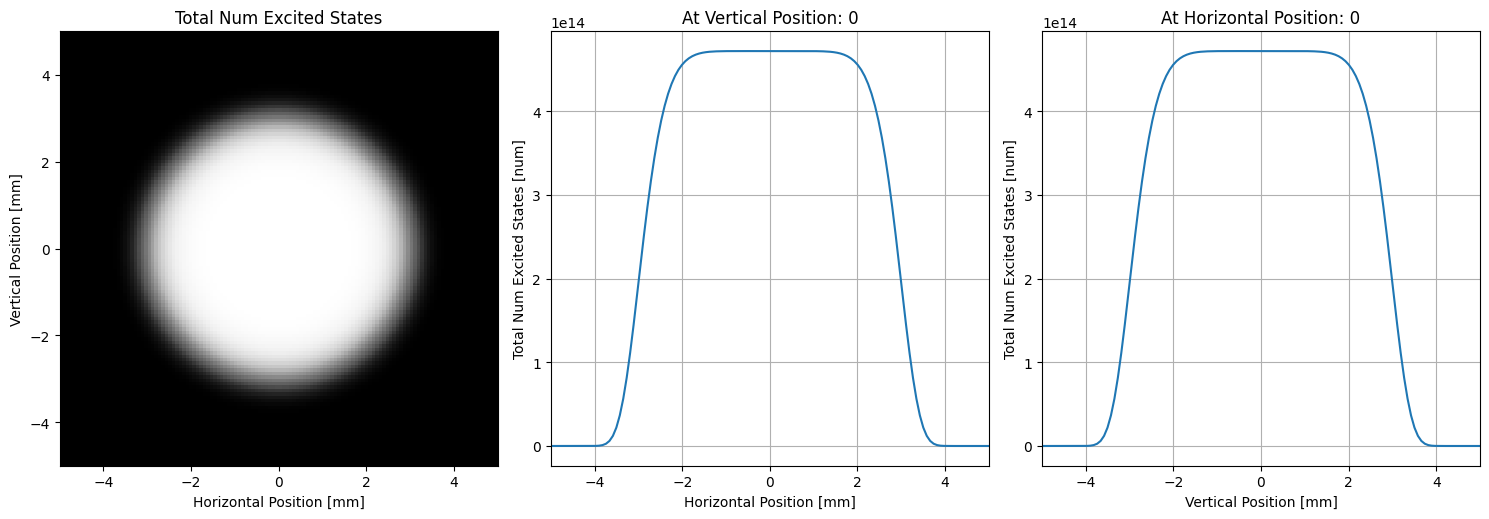

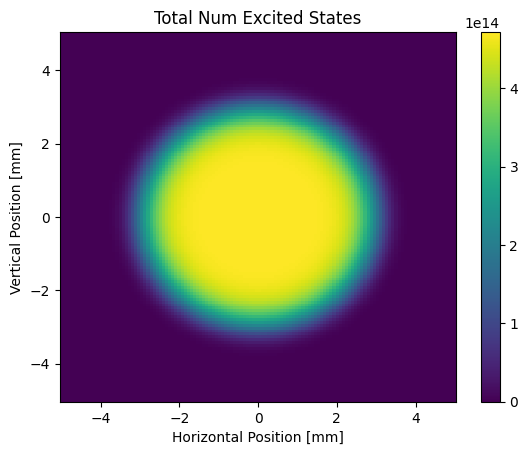

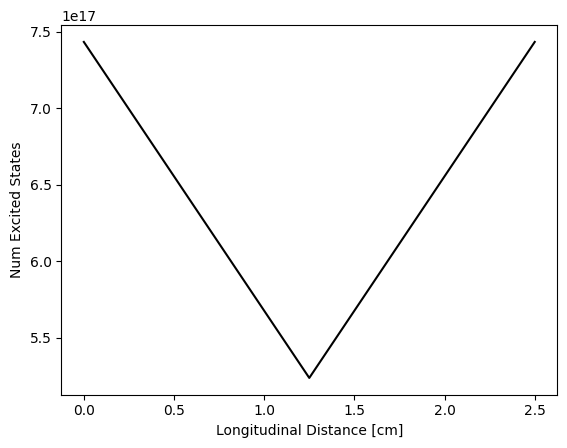

In [6]:
crystal_params_1 = PKDict(
    length      = 0.025, # [m]
    nslice      = num_crystal_slices,
    n0          = [1.76 for _ in range(num_crystal_slices)],
    n2          = [0.00 for _ in range(num_crystal_slices)],
    l_scale     = np.sqrt(np.pi)*w0,
    pop_inversion_n_cells=128,
    pop_inversion_mesh_extent=0.01/2.0,  # [m]
    pop_inversion_crystal_alpha=106.4,  # [1/m], 1.064 1/cm
    pop_inversion_pump_waist=3.82e-3,  # [m]
    pop_inversion_pump_wavelength=532.0e-9,  # [m]
    pop_inversion_pump_energy=0.82,  # [J], pump laser energy onto the crystal
    pop_inversion_pump_type="dual",
    pop_inversion_pump_gaussian_order=8,
    pop_inversion_pump_rep_rate=1.0,
)

crystal_1 = crystal.Crystal(crystal_params_1)
n0_slice_array, n2_slice_array1, full_crystal_abcd_mat_1 = crystal_1.calc_n0n2(set_n=True, method="fenics", heat_load="hog")

if prop_type == 'abcd_lct':
    crystal_params_1.A = full_crystal_abcd_mat_1[0][0]
    crystal_params_1.B = full_crystal_abcd_mat_1[0][1]
    crystal_params_1.C = full_crystal_abcd_mat_1[1][0]
    crystal_params_1.D = full_crystal_abcd_mat_1[1][1]
    crystal_params_1.nslice = 1
    crystal_params_1.n0 = [1.76]
    crystal_params_1.n2 = [0.00]
    crystal_1 = crystal.Crystal(crystal_params_1)
    
plot_excited_states(crystal_1)

### Crystal 2 ('Amp3')

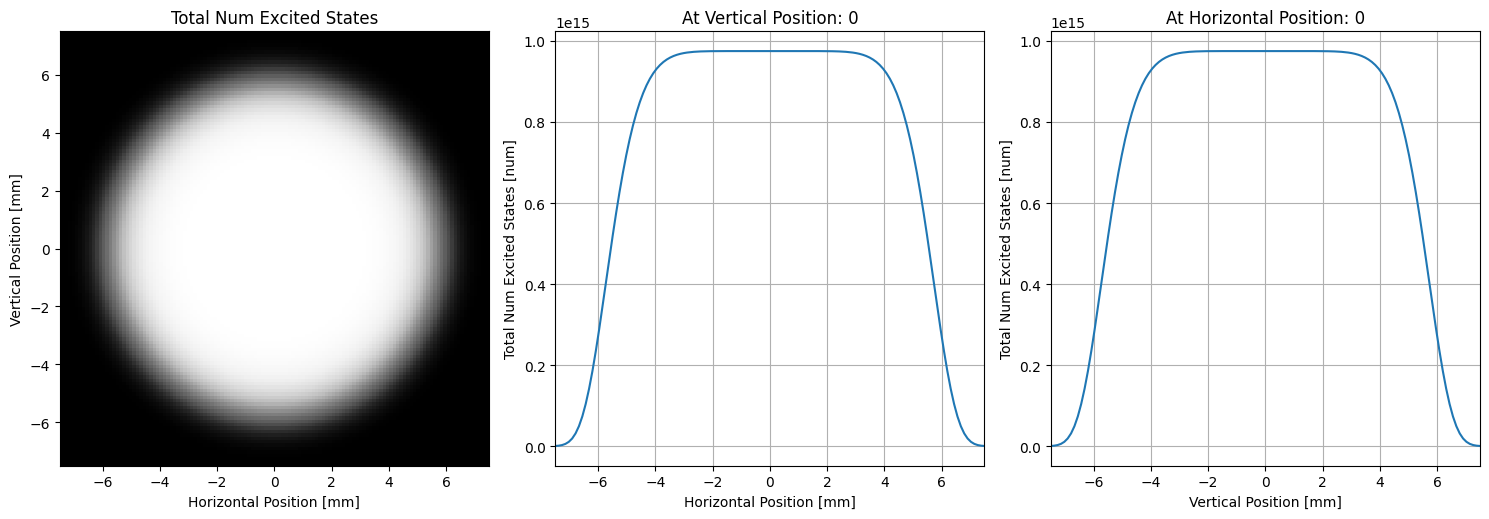

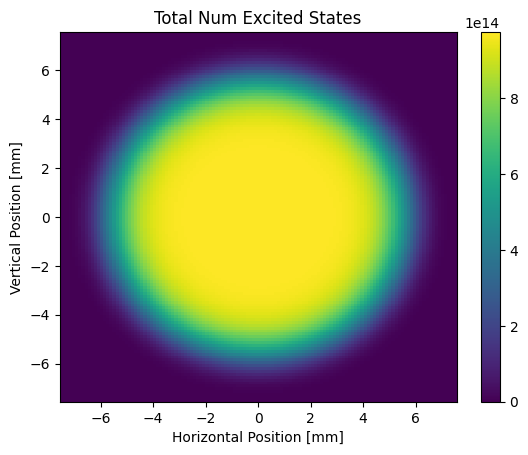

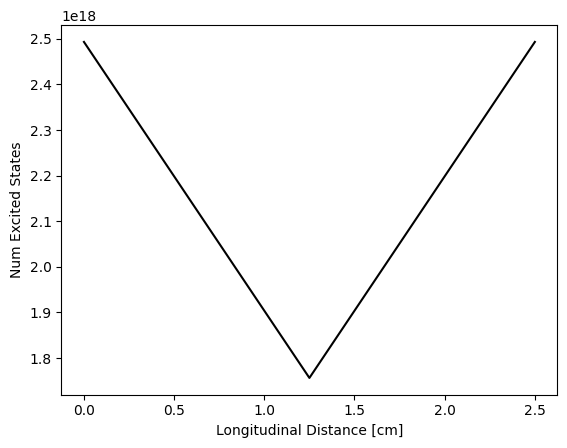

In [7]:
crystal_params_2 = PKDict(
    length      = 0.025, # [m]
    nslice      = num_crystal_slices,
    n0          = [1.76 for _ in range(num_crystal_slices)],
    n2          = [0.00 for _ in range(num_crystal_slices)],
    l_scale     = np.sqrt(np.pi)*w0,
    pop_inversion_n_cells=128,
    pop_inversion_mesh_extent=0.015/2.0,  # [m]
    pop_inversion_crystal_alpha=106.4,  # [1/m], 1.064 1/cm
    pop_inversion_pump_waist=7.3e-3,  # [m]
    pop_inversion_pump_wavelength=532.0e-9,  # [m]
    pop_inversion_pump_energy=2.75,  # [J], pump laser energy onto the crystal
    pop_inversion_pump_type="dual",
    pop_inversion_pump_gaussian_order=8,
    pop_inversion_pump_rep_rate=1.0,
)

crystal_2 = crystal.Crystal(crystal_params_2)
n0_slice_array, n2_slice_array2, full_crystal_abcd_mat_2 = crystal_2.calc_n0n2(set_n=True, method="fenics", heat_load="hog")

if prop_type == 'abcd_lct':
    crystal_params_2.A = full_crystal_abcd_mat_2[0][0]
    crystal_params_2.B = full_crystal_abcd_mat_2[0][1]
    crystal_params_2.C = full_crystal_abcd_mat_2[1][0]
    crystal_params_2.D = full_crystal_abcd_mat_2[1][1]
    crystal_params_2.nslice = 1
    crystal_params_2.n0 = [1.76]
    crystal_params_2.n2 = [0.00]
    crystal_2 = crystal.Crystal(crystal_params_2)
    
plot_excited_states(crystal_2)

### Crystal 3 ('Amp4')

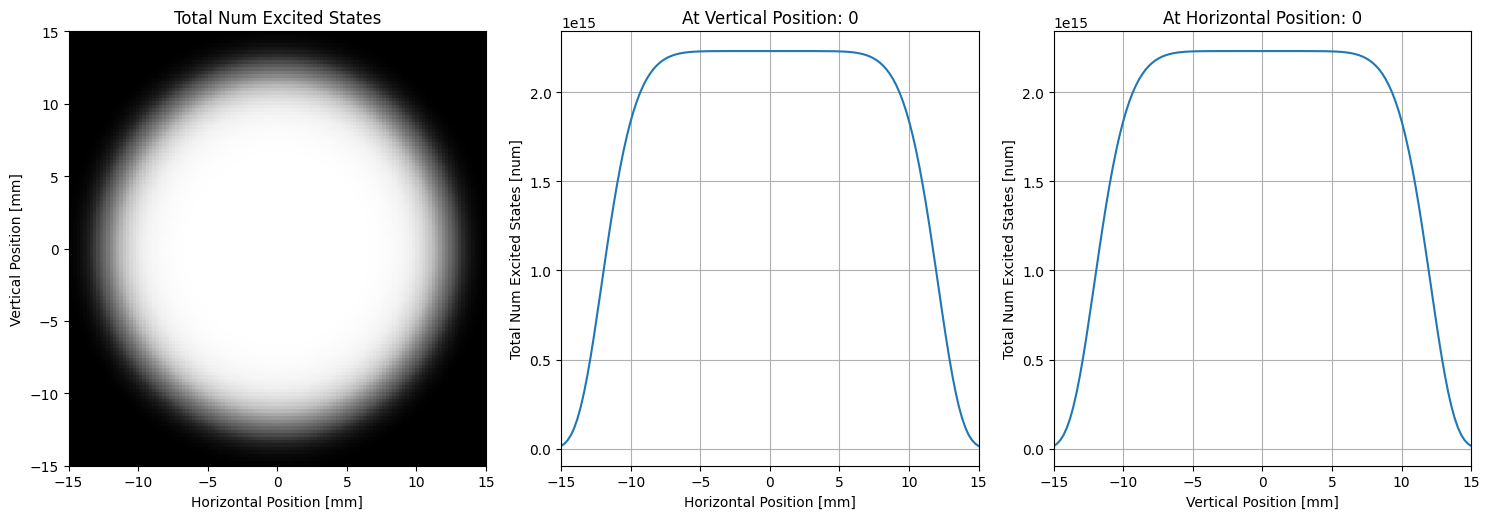

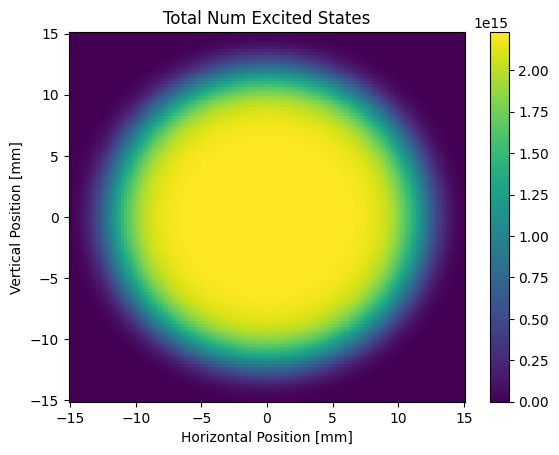

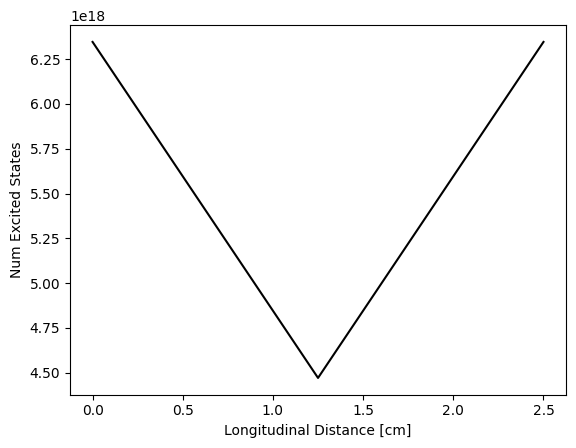

In [8]:
crystal_params_3 = PKDict(
    length      = 0.025, # [m]
    nslice      = num_crystal_slices,
    n0          = [1.76 for _ in range(num_crystal_slices)],
    n2          = [0.00 for _ in range(num_crystal_slices)],
    l_scale     = np.sqrt(np.pi)*w0,
    pop_inversion_n_cells=128,
    pop_inversion_mesh_extent=0.03/2.0,  # [m]
    pop_inversion_crystal_alpha=106.4,  # [1/m], 1.064 1/cm
    pop_inversion_pump_waist=15.4e-3,  # [m]
    pop_inversion_pump_wavelength=532.0e-9,  # [m]
    pop_inversion_pump_energy=7.0,  # [J], pump laser energy onto the crystal
    pop_inversion_pump_type="dual",
    pop_inversion_pump_gaussian_order=8,
    pop_inversion_pump_rep_rate=1.0,
)

crystal_3 = crystal.Crystal(crystal_params_3)
n0_slice_array, n2_slice_array3, full_crystal_abcd_mat_3 = crystal_3.calc_n0n2(set_n=True, method="fenics", heat_load="hog") #method="analytical"

if prop_type == 'abcd_lct':
    crystal_params_3.A = full_crystal_abcd_mat_3[0][0]
    crystal_params_3.B = full_crystal_abcd_mat_3[0][1]
    crystal_params_3.C = full_crystal_abcd_mat_3[1][0]
    crystal_params_3.D = full_crystal_abcd_mat_3[1][1]
    crystal_params_3.nslice = 1
    crystal_params_3.n0 = [1.76]
    crystal_params_3.n2 = [0.00]
    crystal_3 = crystal.Crystal(crystal_params_3)
    
plot_excited_states(crystal_3)

## Drift Matrix

In [9]:
# Drift length [m]
L_Drift = 2.75/2.0 # [m]

# instantiate an srw drift
e_drift_srw = lens.Drift_srw(L_Drift)

# instantiate an lct drift
e_drift_lct = lens.Drift_lct(L_Drift, l_scale)

***
## Initial Intensity and Phase

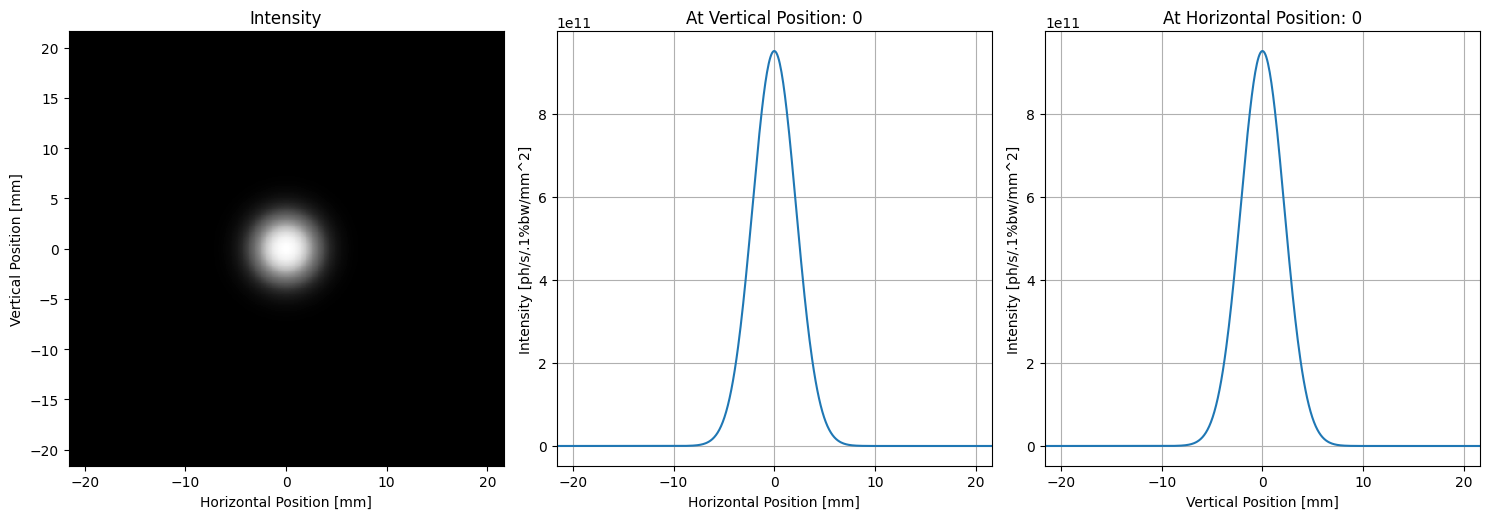

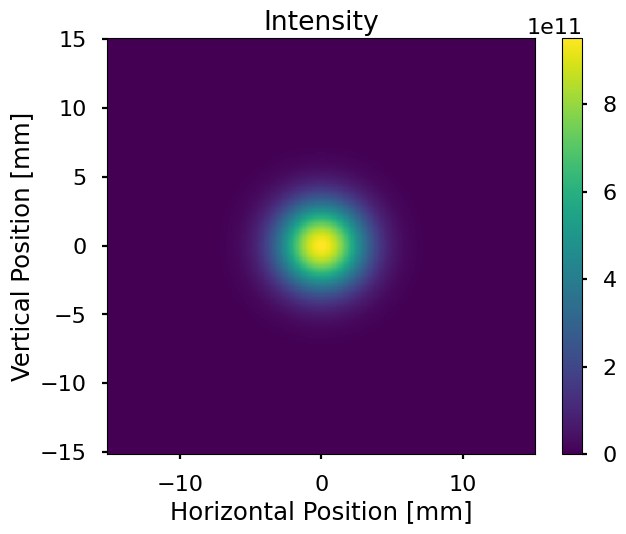

(357,) (357,) (357, 357)


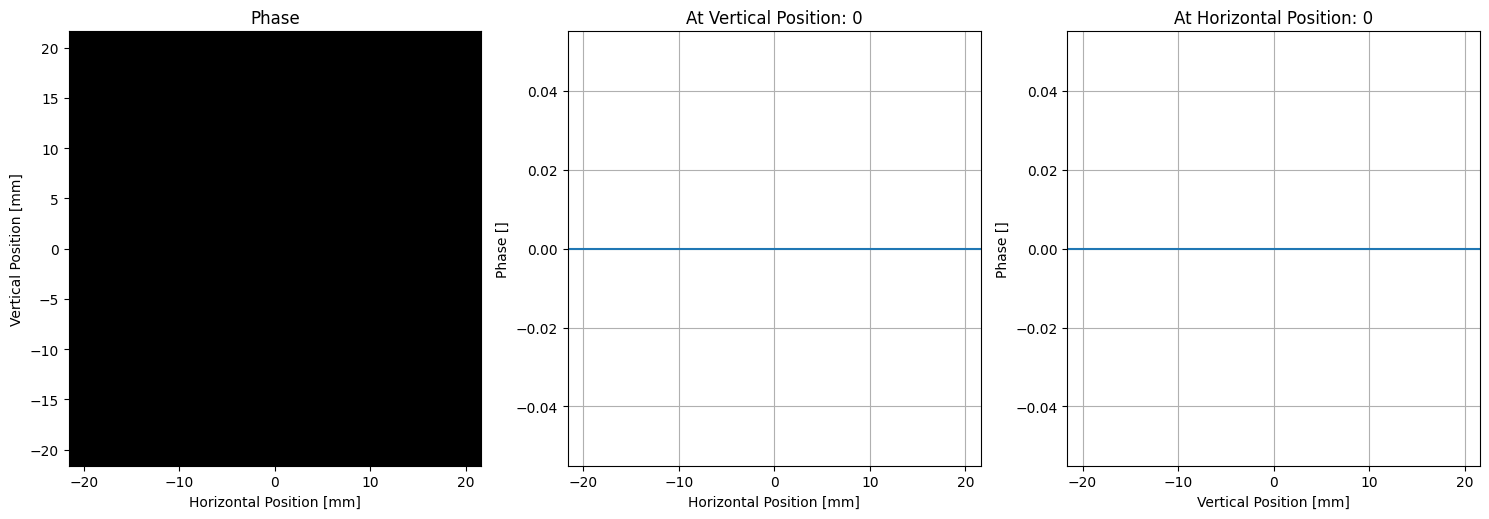

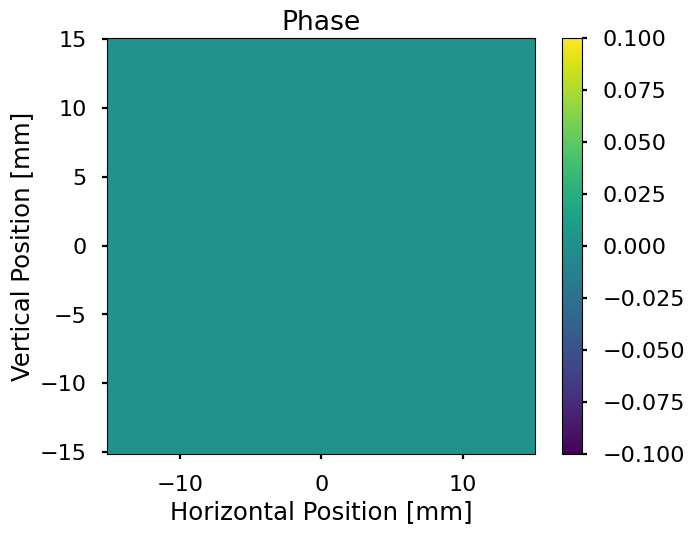

In [10]:
thisPulse_initial = pulse.LaserPulse(params)
thisPulse_initial.zero_phase()
plot_all(thisPulse_initial)

In [11]:
print(thisPulse_initial.calc_total_energy())

0.0020056164748069333


In [12]:
rayleigh_length = np.pi * (thisPulse_initial.sigx_waist)**2.0 / (thisPulse_initial._lambda0)
print('Rayleigh Length:', round(rayleigh_length,3), ' m')
print('RMS bunch length:', round(thisPulse_initial.sig_s,3), ' m')

Rayleigh Length: 18.337  m
RMS bunch length: 0.054  m


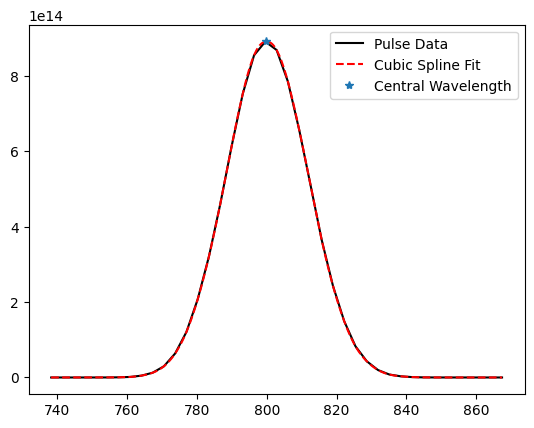

In [13]:
pass_number = np.arange(11)
central_wavelength = np.zeros(len(pass_number))
mean_wavelength = np.zeros(len(pass_number))
central_wavelength[0], mean_wavelength[0] = thisPulse_initial.central_and_mean_wavelength(plot=True)

***
## 4 Passes Through First Crystal ('Amp2')

In [ ]:
thisPulse_firstCrystal = copy.deepcopy(thisPulse_initial)
num_passes = 4

for prop_index in np.arange(num_passes):
    print('Pass ',prop_index+1)
    
    thisPulse_firstCrystal = e_drift_srw.propagate(thisPulse_firstCrystal)
    
    # Crystal
    thisPulse_firstCrystal = crystal_1.propagate(thisPulse_firstCrystal, prop_type, gain, radial_n2)
    plot_excited_states(crystal_1)
    
    thisPulse_firstCrystal = e_drift_srw.propagate(thisPulse_firstCrystal)
    
    if prop_index < (num_passes -1):
        thisPulse_firstCrystal.ideal_mirror_180()

    central_wavelength[1 + prop_index], mean_wavelength[1 + prop_index] = thisPulse_firstCrystal.central_and_mean_wavelength(plot=True)
        
plot_all(thisPulse_firstCrystal)
print(thisPulse_firstCrystal.calc_total_energy())

***
## Beamsplitter

In [ ]:
beamsplitter = lens.Beamsplitter(beamsplitter_transmitted_frac)

thisPulse_beamsplitter = copy.deepcopy(thisPulse_firstCrystal)
thisPulse_beamsplitter = beamsplitter.propagate(thisPulse_beamsplitter)
plot_all(thisPulse_beamsplitter)
print(thisPulse_beamsplitter.calc_total_energy())

***
## Telescope 1

In [ ]:
f1 = -0.1
f2 = 0.2
d1 = 1.9
d2 = 0.1
d3 = 0.54

telescope_1 = lens.Telescope_lct(f1, f2, d1, d2, d3, l_scale)

thisPulse_telescope1 = copy.deepcopy(thisPulse_beamsplitter)
thisPulse_telescope1 = telescope_1.propagate(thisPulse_telescope1)
plot_all(thisPulse_telescope1)
print(thisPulse_telescope1.calc_total_energy())

***
## 3 Passes Through Second Crystal ('Amp3')

In [ ]:
thisPulse_secondCrystal = copy.deepcopy(thisPulse_telescope1)
num_passes = 3

for prop_index in np.arange(num_passes):
    print('Pass ', prop_index+1)

    thisPulse_secondCrystal = e_drift_srw.propagate(thisPulse_secondCrystal)
    
    # Crystal
    thisPulse_secondCrystal = crystal_2.propagate(thisPulse_secondCrystal, prop_type, gain, radial_n2)
    plot_excited_states(crystal_2)
    
    thisPulse_secondCrystal = e_drift_srw.propagate(thisPulse_secondCrystal)
    
    if prop_index < (num_passes -1):
        thisPulse_secondCrystal.ideal_mirror_180()

    central_wavelength[5 + prop_index], mean_wavelength[5 + prop_index] = thisPulse_secondCrystal.central_and_mean_wavelength(plot=True)
        
plot_all(thisPulse_secondCrystal)
print(thisPulse_secondCrystal.calc_total_energy())

***
## Telescope 2

In [ ]:
f1 = -0.3
f2 = 0.6
d1 = 1.0
d2 = 0.3
d3 = 0.66

telescope_2 = lens.Telescope_lct(f1, f2, d1, d2, d3, l_scale)

thisPulse_telescope2 = copy.deepcopy(thisPulse_secondCrystal)
thisPulse_telescope2 = telescope_2.propagate(thisPulse_telescope2)
plot_all(thisPulse_telescope2)
print(thisPulse_telescope2.calc_total_energy())

***
## 3 Passes Through Third Crystal ('Amp4')

In [ ]:
thisPulse_thirdCrystal = copy.deepcopy(thisPulse_telescope2)
num_passes = 3

for prop_index in np.arange(num_passes):
    print('Pass ', prop_index+1)
    
    thisPulse_thirdCrystal = e_drift_srw.propagate(thisPulse_thirdCrystal)
    
    # Crystal
    thisPulse_thirdCrystal = crystal_3.propagate(thisPulse_thirdCrystal, prop_type, gain, radial_n2)
    plot_excited_states(crystal_3)
    
    thisPulse_thirdCrystal = e_drift_srw.propagate(thisPulse_thirdCrystal)
    
    if prop_index < (num_passes -1):
        thisPulse_thirdCrystal.ideal_mirror_180()
    
    central_wavelength[8 + prop_index], mean_wavelength[8 + prop_index] = thisPulse_thirdCrystal.central_and_mean_wavelength(plot=True)

plot_all(thisPulse_thirdCrystal)
print(thisPulse_thirdCrystal.calc_total_energy())

***
## Final Visualization

In [ ]:
sim_energy = 1.0e3*np.array([thisPulse_initial.calc_total_energy(),
                             thisPulse_firstCrystal.calc_total_energy(),
                             thisPulse_beamsplitter.calc_total_energy(),
                             thisPulse_secondCrystal.calc_total_energy(),
                             thisPulse_thirdCrystal.calc_total_energy()])
amp = np.array([0,1,2,3,4])
plt.figure()
ax = plt.gca()
plt.semilogy(amp, sim_energy, 'k',label="Simulation")
plt.semilogy(amp, np.array([2.0,250.0,110.0,900.0,3360.0]), '--r',label="Experiment")
plt.xlabel(r'Pulse Location in 100TW Amplifier')
plt.ylabel(r'Pulse Energy (mJ)')
plt.legend()
plt.title('Amplification')
plt.tick_params(direction="in")
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['Initial', 'Post Amp2', 'Post Beamsplitter', 'Post Amp3', 'Post Amp4'])
plt.grid()
plt.show()

In [ ]:
print(np.round(sim_energy))

In [ ]:
def calc_three_meshes(laser_pulse):
    wavelength_mesh = np.zeros((laser_pulse.slice[0].bw_nslice+1,laser_pulse.nslice))
    photon_mesh = np.zeros((laser_pulse.slice[0].bw_nslice+1,laser_pulse.nslice))
    intensity_mesh = np.zeros((laser_pulse.slice[0].bw_nslice+1,laser_pulse.nslice))

    for j in np.arange(laser_pulse.nslice):
        thisSlice = laser_pulse.slice[j]
        wavelength_mesh[3,j] = abs(units.calculate_lambda0_from_phE(thisSlice.photon_e_ev * const.e))
        photon_mesh[3,j] = np.sum(thisSlice.n_photons_2d.mesh)
        intensity_mesh[3,j] = np.sum(srwutil.calc_int_from_elec(thisSlice.wfr))
        for k in np.arange(thisSlice.bw_nslice):
            thisSubSlice = thisSlice.bandwidth_slice[k]
            bw_ind = int(3 + thisSubSlice.sign * thisSubSlice.rms_int)
            wavelength_mesh[bw_ind,j] = abs(units.calculate_lambda0_from_phE(thisSubSlice.photon_e_ev * const.e))    
            photon_mesh[bw_ind,j] = np.sum(thisSubSlice.n_photons_2d.mesh)
            intensity_mesh[bw_ind,j] = np.sum(srwutil.calc_int_from_elec(thisSubSlice.wfr))
    
    return wavelength_mesh, photon_mesh, intensity_mesh

In [ ]:
wavelength_mesh_init, photon_mesh_init, intensity_mesh_init = calc_three_meshes(thisPulse_initial)
wavelength_mesh_first, photon_mesh_first, intensity_mesh_first = calc_three_meshes(thisPulse_firstCrystal)
wavelength_mesh_beamsplitter, photon_mesh_beamsplitter, intensity_mesh_beamsplitter = calc_three_meshes(thisPulse_beamsplitter)
wavelength_mesh_second, photon_mesh_second, intensity_mesh_second = calc_three_meshes(thisPulse_secondCrystal)
wavelength_mesh_final, photon_mesh_final, intensity_mesh_final = calc_three_meshes(thisPulse_thirdCrystal)

In [ ]:
n_slice = np.arange(thisPulse_initial.nslice)+1
n_subslice = np.arange(thisPulse_initial.slice[0].bw_nslice+1)-3

with plt.style.context(('seaborn-poster')):
    fig = plt.figure(figsize=(4.6*2,3.6*2))
    ax = fig.gca()
    plt.pcolormesh(n_slice, n_subslice, wavelength_mesh_init*1.0e9, cmap=plt.cm.viridis, shading='auto')
    plt.colorbar()
    ax.set_ylabel(r'Subslice Number')
    ax.set_xlabel(r'Slice Number')
    ax.set_title('Wavelength')
    plt.show()    

In [ ]:
amp = np.array([0,1,2,3])

weight_0 = photon_mesh_init / np.sum(photon_mesh_init)
weight_1 = photon_mesh_first / np.sum(photon_mesh_first)
weight_2 = photon_mesh_second / np.sum(photon_mesh_second)
weight_3 = photon_mesh_final / np.sum(photon_mesh_final)

wavelength = np.array([np.sum(wavelength_mesh_init*weight_0),
                       np.sum(wavelength_mesh_first*weight_1),
                       np.sum(wavelength_mesh_second*weight_2),
                       np.sum(wavelength_mesh_final*weight_3)])
frequency = const.c / wavelength

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Pulse Location in 100TW Amplifier')
ax1.set_ylabel('Mean Wavelength (nm)', color=color)
ax1.plot(amp, wavelength*1e9, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['Initial', 'Post Amp2', 'Post Amp3', 'Post Amp4'])

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Frequency (Hz)', color=color) 
ax2.plot(amp, frequency, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
laml=750 
lamr=850

data1 = np.load('regen_out_data.npy')
wavelength1=data1[0,:]
inl1=np.argmin(abs(wavelength1-laml))
inr1=np.argmin(abs(wavelength1-lamr))
spec1=data1[1,:]
spec1=spec1-np.mean(spec1[1:100])
spec1=spec1/np.max(spec1[inl1:inr1])

data2 = np.load('amp2_data.npy')
wavelength2=data2[0,:]
inl2=np.argmin(abs(wavelength2-laml))
inr2=np.argmin(abs(wavelength2-lamr))
spec2=data2[1,:]
spec2=spec2-np.mean(spec2[1:100])
spec2=spec2/np.max(spec2[inl2:inr2])

data3 = np.load('amp3_data.npy')
wavelength3=data3[0,:]
inl3=np.argmin(abs(wavelength3-laml))
inr3=np.argmin(abs(wavelength3-lamr))
spec3=data3[1,:]
spec3=spec3-np.mean(spec3[1:100])
spec3=spec3/np.max(spec3[inl3:inr3])

data4 = np.load('amp4_data.npy')
wavelength4=data4[0,:]
inl4=np.argmin(abs(wavelength4-laml))
inr4=np.argmin(abs(wavelength4-lamr))
spec4=data4[1,:]
spec4=spec4-np.mean(spec4[1:100])
spec4=spec4/np.max(spec4[inl4:inr4])

lamc=799.5

plt.figure(figsize=(4.6*2.0,3.6*1.2))
# plt.set(gcf,'color',[1 1 1])
# plt.set(gca,'fontsize',14)
plt.plot(wavelength1,spec1,'g--', label='Regen out')
plt.plot(wavelength2-2.6,0.95*spec2,'g',label='Regen out manipulated') #'Color', [0.2,0.8,0.2], 
plt.plot(wavelength2,spec2+0.2,'k', label='Amp2 out')
plt.plot(wavelength3,spec3+0.4,'r', label='Amp3 out')
plt.plot(wavelength4,spec4+0.6,'b', label='Amp4 out')
plt.plot(np.array([lamc, lamc]),np.array([0, 1.8]),'--g')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Spectrum Data')
plt.xlim(760, 850)
plt.ylim(-0.02, 1.7)
plt.title('n=1e17cm-3, 780nm, L=20cm, Lengthening x1.0015')
plt.legend()
plt.show()

In [ ]:
wavelength_0 = wavelength_mesh_init.flatten() * 1e9
wavelength_1 = wavelength_mesh_first.flatten() * 1e9
wavelength_2 = wavelength_mesh_second.flatten() * 1e9
wavelength_3 = wavelength_mesh_final.flatten() * 1e9

intensity_0f = intensity_mesh_init.flatten()
intensity_1f = intensity_mesh_first.flatten()
intensity_2f = intensity_mesh_second.flatten()
intensity_3f = intensity_mesh_final.flatten()

wavelenth_values, intensity_0 = pulse.bin_arrays(intensity_0f, wavelength_0, num_laser_slices)
wavelenth_values, intensity_1 = pulse.bin_arrays(intensity_1f, wavelength_1, num_laser_slices)
wavelenth_values, intensity_2 = pulse.bin_arrays(intensity_2f, wavelength_2, num_laser_slices)
wavelenth_values, intensity_3 = pulse.bin_arrays(intensity_3f, wavelength_3, num_laser_slices)

plt.figure(figsize=(4.6*2.0,3.6*1.2))
plt.plot(wavelength2-2.6,0.95*spec2/np.max(0.95*spec2[inl2:inr2]),'g--',label='E: Regen out')
plt.plot(wavelength2,spec2/np.max(spec2[inl2:inr2])+0.2,'k--', label='E: Amp2 out')
plt.plot(wavelength3,spec3/np.max(spec3)+0.4,'r--', label='E: Amp3 out')
plt.plot(wavelength4,spec4/np.max(spec4)+0.6,'b--', label='E: Amp4 out')
plt.plot(wavelenth_values, intensity_0/np.max(intensity_0) + 0.0, 'g', label='S: Regen Out')
plt.plot(wavelenth_values, intensity_1/np.max(intensity_1) + 0.2, 'k', label='S: Amp2 Out')
plt.plot(wavelenth_values, intensity_2/np.max(intensity_2) + 0.4, 'r', label='S: Amp3 Out')
plt.plot(wavelenth_values, intensity_3/np.max(intensity_3) + 0.6, 'b', label='S: Amp4 Out')
plt.xlabel(r'Wavelength (nm)')
plt.ylabel(r'Spectrum Data: normalized sum intensity')
plt.legend()
plt.title('Study of Red-Shifting Versus Amplification')
plt.tick_params(direction="in")
plt.xlim(760,850)
plt.ylim(-0.02, 1.7)
plt.grid()
plt.show()

In [ ]:
experimental_central_wavelength = np.array([800.3,800.5,800.9,803,805.2,805.6,806.6,808,809.5,811.2,812.4])

plt.figure()
plt.plot(pass_number, mean_wavelength *1e9, 'k', label='Simulation: Mean $\lambda$')
# plt.plot(pass_number, central_wavelength, 'b', label='Simulation: Central $\lambda$')
plt.plot(pass_number, experimental_central_wavelength, 'r', label='Experiment: Central $\lambda$')
plt.xlabel('Pass Number')
plt.ylabel('Wavelength (nm)')#('Central Wavelength (nm)')#
plt.legend()
plt.tick_params(direction="in")
plt.grid()
plt.show()